In [1]:
import sys
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from classic_descriptors.featurisation import process_dataframe
import dft_descriptors.prepocessing as pp
import dft_descriptors.featurisation as ft
from analysis import analysis_stratification_influence, analysis_train_set_size, analysis_stratification_influence_substrates

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_train_test_size_influence(metric_values, baseline_values):
    metric_mean = np.mean(metric_values, axis=1)
    metric_lower = np.percentile(metric_values, 5, axis=1)
    metric_upper = np.percentile(metric_values, 95, axis=1)

    baseline_mean = np.mean(baseline_values, axis=1)
    baseline_lower = np.percentile(baseline_values, 5, axis=1)
    baseline_upper = np.percentile(baseline_values, 95, axis=1)
    
    # How does (with fixed test set) performance improves as the training set size augments?
    plt.figure(figsize=(10, 10))

    plt.plot(sizes, metric_mean, label='Model predictions_no_scope/opt_info')
    plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

    #plt.plot(sizes_o, metric_mean_o, label='Model predictions_scope/opt_info')
    #plt.fill_between(sizes_o, metric_lower_o, metric_upper_o, alpha=0.5)

    plt.plot(sizes, baseline_mean, c='r', label='Baseline')
    plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

    plt.xlabel("Training set size (number of reactions)", fontsize=25)
    plt.ylabel("Predictive performance", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()
    
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

def meca_2_origin(mechanisms, meca):
    mecas_indexes = np.where(mechanisms==meca)[0]
    origin = origins[mecas_indexes[0]]
    return origin

# Preprocessing for dft featurization

In [3]:
df = pd.read_csv("data_csv/Data_test11262021.csv", sep = ',')

In [4]:
df2 = pp.preprocess(df)
df2["Lewis Acid"] = df2["Lewis Acid"].fillna('NoLewisAcid')
df2["Lewis Acid"] = df2["Lewis Acid"].replace('nan', 'NoLewisAcid')

In [5]:
df2 = pp.preprocess(df)
df2["Lewis Acid"] = df2["Lewis Acid"].fillna('NoLewisAcid')
df2["Lewis Acid"] = df2["Lewis Acid"].replace('nan', 'NoLewisAcid')

Lewis_Acids_to_drop = ['O=C(O[Cs])O[Cs]', 'Cl[Cs]', 
                       'O=S(=O)(O[Sc](OS(=O)(=O)C(F)(F)F)OS(=O)(=O)C(F)(F)F)C(F)(F)F', 
                       'F[Cs]', 'O=P(O[Na])(O[Na])O[Na]', '[Rb+]',
                       'CC(C)(C)C(=O)O[Cs]', '[Cs+]', 'CC(=O)O[Cu]OC(C)=O', 'F[Sr]F']

for al in Lewis_Acids_to_drop:
    df2 = df2[df2["Lewis Acid"] != al]
    
df2 = df2.reset_index(drop=True)

In [6]:
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df2, data_path="data_csv/", origin=False)

NoLigand


# Global performances

In [7]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = r2_score
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=2)

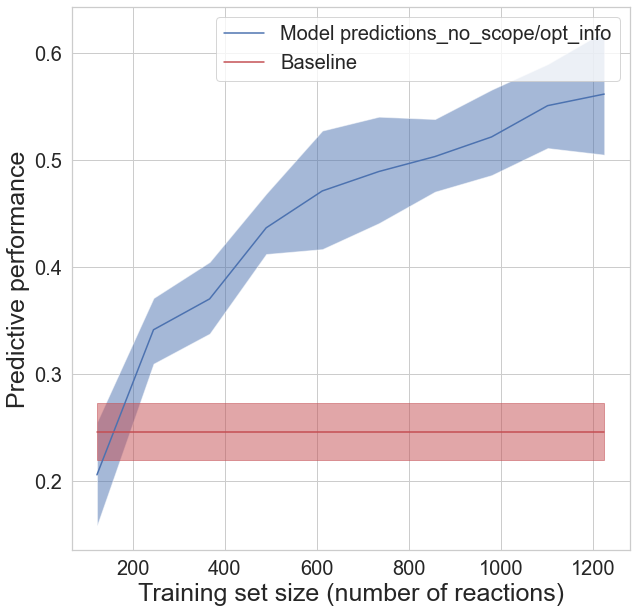

In [8]:
plot_train_test_size_influence(metric_values, baseline_values)

# Performances on  a subset of mechanisms

In [9]:
df2["Mechanism"].unique()
Suzuki_like = ['Murahashi', 'Negishi', 'Kumada', 'Suzuki', 'Hiyama', 'Al _coupling']
Buchwald_like = ['Buchwald', 'P_coupling']
Insertion = ['CO2 Insertion', 'Isocyanates']

In [10]:
# training on the Suzuki_like subset

In [11]:
df3 = df2[df2["Mechanism"].isin(Suzuki_like)]
df3.reset_index(inplace=True)

In [12]:
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df3, data_path="data_csv/", origin=False)
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=2)

NoLigand


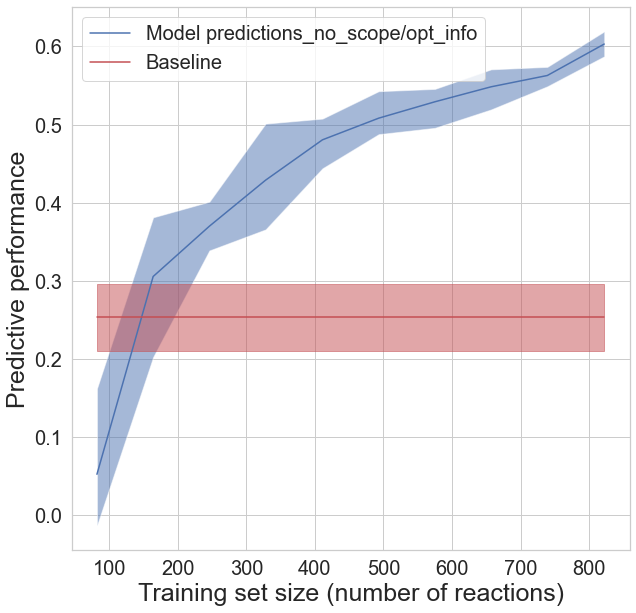

In [13]:
plot_train_test_size_influence(metric_values, baseline_values)

In [14]:
# training on the non Suzuki_like subset

NoLigand


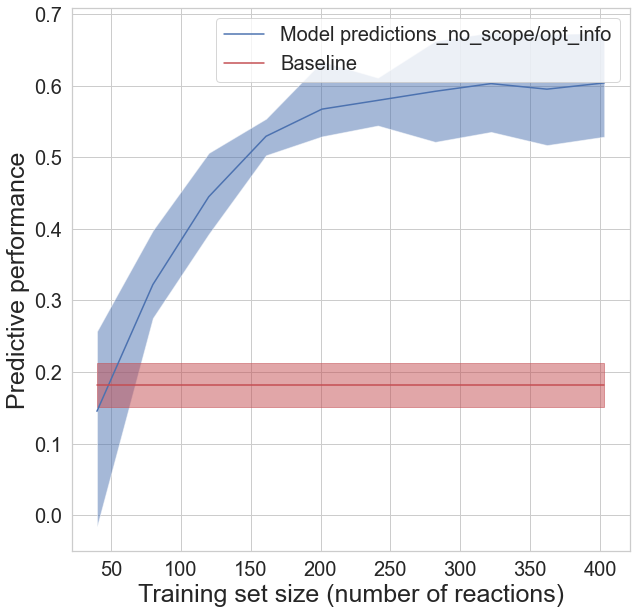

In [15]:
df3 = df2[df2["Mechanism"].isin(Suzuki_like) == False]
df3.reset_index(inplace=True)
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df3, data_path="data_csv/", origin=False)
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=2)
plot_train_test_size_influence(metric_values, baseline_values)

# Improvement of the Suzuki-like model on the Suzuki-like subset

In [16]:
df3 = df2[df2["Mechanism"].isin(Suzuki_like)]
df3.reset_index(inplace=True)
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df3, data_path="data_csv/", origin=False)

NoLigand


In [52]:
for meca in df3["Mechanism"].unique():
    print(meca, "number of reactions in this meca = ", len(df3[df3["Mechanism"]==meca]))

Murahashi number of reactions in this meca =  52
Negishi number of reactions in this meca =  68
Kumada number of reactions in this meca =  321
Suzuki number of reactions in this meca =  484
Hiyama number of reactions in this meca =  50
Al _coupling number of reactions in this meca =  53


In [53]:
for doi in df3["DOI"].unique():
    print(doi, "number of reactions in this doi = ", len(df3[df3["DOI"]==doi]))

https://doi.org/10.1002/chem.201603436 number of reactions in this doi =  66
https://doi.org/10.1021/acs.orglett.6b02656 number of reactions in this doi =  36
https://doi.org/10.1021/jo4005537 number of reactions in this doi =  57
https://doi.org/10.1021/ja8056503 number of reactions in this doi =  79
https://doi.org/10.1021/ja412107b number of reactions in this doi =  50
https://doi.org/10.1021/ja806244b number of reactions in this doi =  13
https://doi.org/10.1021/ol101592r number of reactions in this doi =  27
https://doi.org/10.1039/C3CC46663A number of reactions in this doi =  62
https://doi.org/10.1021/ja906477r number of reactions in this doi =  10
https://doi.org/10.1021/ja907700e number of reactions in this doi =  27
https://doi.org/10.1021/ol9029534 number of reactions in this doi =  8
https://doi.org/10.1021/jo1024464 number of reactions in this doi =  23
https://doi.org/10.1021/ja200398c number of reactions in this doi =  19
https://doi.org/10.1246/cl.2011.913 number of rea

## Low data regime : improvement of the other mechanisms

In [54]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.95, n_iterations=2)


In [55]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)

In [56]:
unique_stratification

array(['Al _coupling', 'Hiyama', 'Kumada', 'Murahashi', 'Negishi',
       'Suzuki'], dtype='<U12')

In [57]:
mecha = mechanisms
orig = [meca_2_origin(mechanisms, x) for x in unique_stratification]

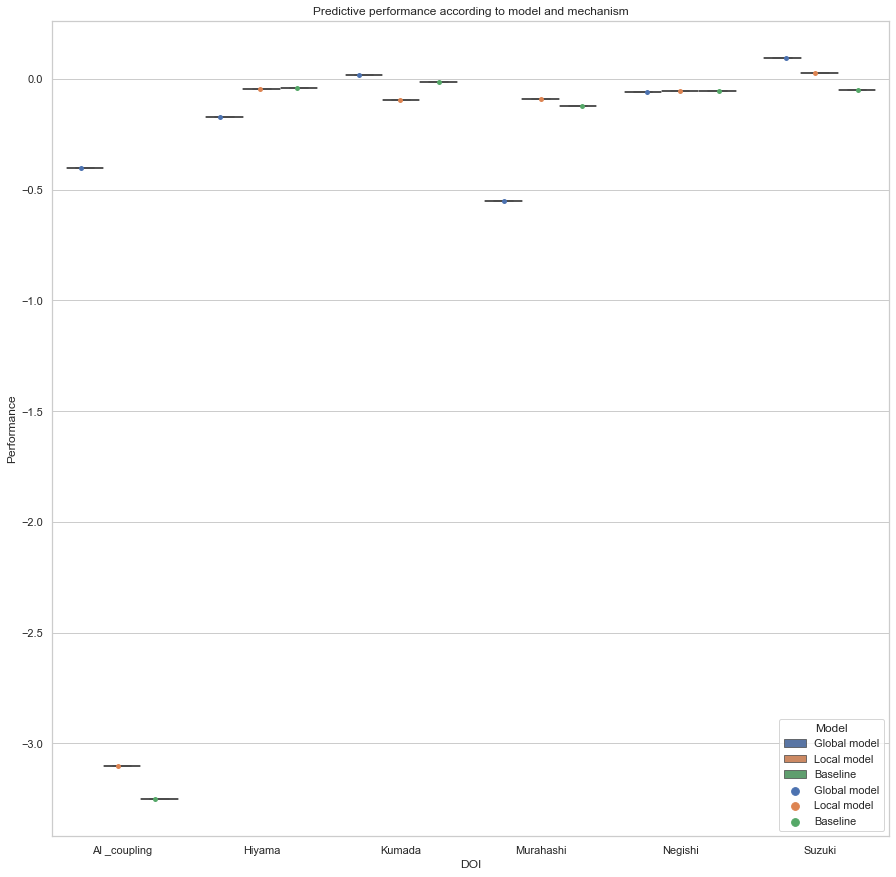

In [58]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))
global_df = pd.DataFrame(zip(metric_augmented, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_standalone, sizes, unique_stratification, mecha, orig, ["Local model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_standalone, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

Display_df = pd.concat([global_df, local_df, baseline_df])
plt.title("Predictive performance according to model and mechanism")
#plt.ylim(-5, 5)
sns.stripplot(x = "DOI", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "DOI", y="Performance",  data=display_df, hue="Model", dodge=True)
plt.show()

## High data regime : improvement of adding out of mechanism data in the Suzuki-like subset

In [78]:
metric_mechanism, metric_augmented_mechanism, metric_baseline_mechanism, _, unique_stratification_mechanism, sizes_mechanism = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.2, n_iterations=100)

In [79]:
mecha = mechanisms
orig = [meca_2_origin(mechanisms, x) for x in unique_stratification_mechanism]

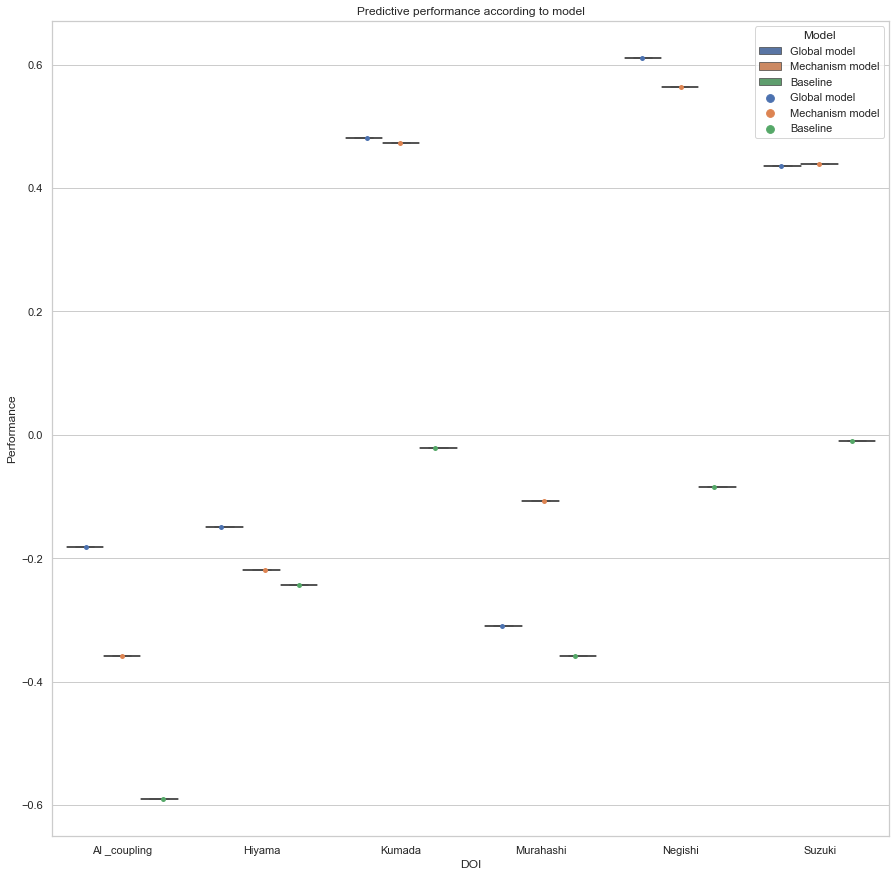

In [80]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(np.mean(metric_augmented_mechanism, axis=1), sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(np.mean(metric_mechanism, axis=1), sizes, unique_stratification, mecha, orig, ["Mechanism model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(np.mean(metric_baseline_mechanism, axis=1), sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "DOI", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "DOI", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

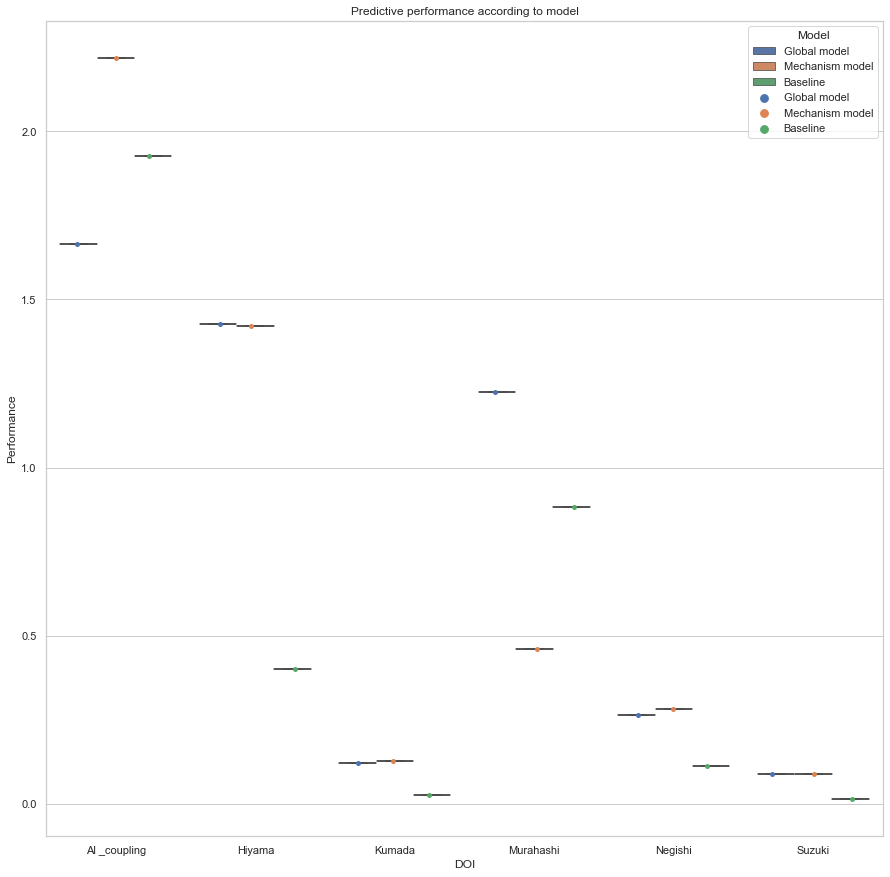

In [81]:
plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(np.std(metric_augmented_mechanism, axis=1), sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(np.std(metric_mechanism, axis=1), sizes, unique_stratification, mecha, orig, ["Mechanism model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(np.std(metric_baseline_mechanism, axis=1), sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "DOI", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "DOI", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

In [82]:
# Distribution of performance increase, global model vs baseline, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.show()

ValueError: Could not interpret input 'Performance increase'

In [17]:
# Performances on scope + A-X/C-O featurisation only

In [18]:
df = pd.read_csv("data_csv/Data_test11262021.csv", sep = ',')
df = df[df["type of data (Optimisation or scope)"]=='Scope']
df.reset_index(inplace=True)
df2 = pp.preprocess(df)

In [20]:
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df2, data_path="data_csv/", origin=False, AX_sub_only=True )

NoLigand


In [21]:
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=2)

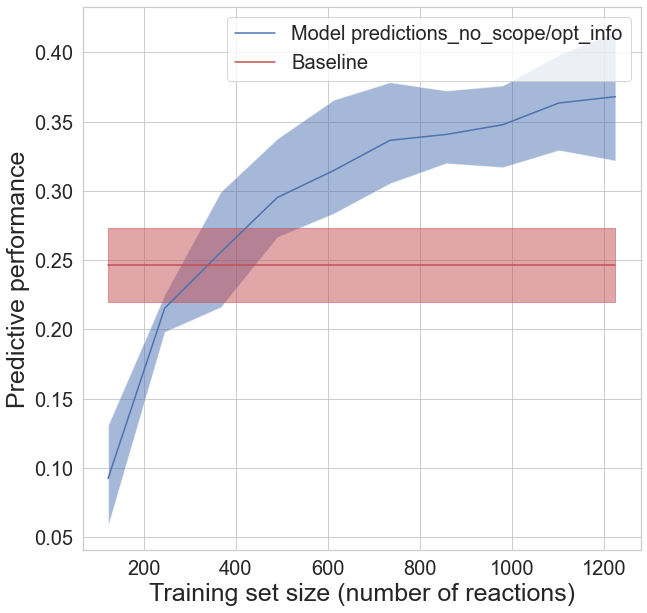

In [22]:
plot_train_test_size_influence(metric_values, baseline_values)

In [ ]:
# Improvement of the global model on the non Suzuki-like subset

In [ ]:
df3 = df2[df2["Mechanism"].isin(Suzuki_like) == False]
df3.reset_index(inplace=True)
for meca in df3["Mechanism"].unique():
    print(meca, "number of reactions in this meca = ", len(df3[df3["Mechanism"]==meca]))
# discard P_coupling :
df3 = df3[df3["Mechanism"] != 'P_coupling']